In [1]:
# imports

import itertools
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
import tensorly as tl
import tlviz
import xarray as xr

from barnacle.tensors import SparseCPTensor
from functools import reduce
from matplotlib import pyplot as plt
from pathlib import Path
from tensorly.cp_tensor import CPTensor
from tlab.cp_tensor import load_cp_tensor

# ignore chained assignment warning in pandas
pd.set_option('mode.chained_assignment', None)


In [2]:
# helpful functions
    
# function to select subset of indices in cp tensor
def subset_cp_tensor(cp_tensor, subset_indices):
    '''Selects subset of cp_tensor based on provided indices
    
    Parameters
    ----------
    cp_tensor : tensorly.CPTensor
        CPTensor object with (weights, factors).
    subset_indices : dict(int: index-like)
        Dictionary with mode as key and value an integer index of 
        the positions to be downselected from `cp_tensor`.
        Example: {1: [0, 1, 3, 4, 5, 8]}
        
    Returns
    -------
    subset_cp : tensorly.CPTensor
        Subset CPTensor.
    '''
    weights, factors = cp_tensor
    new_factors = factors.copy()
    for mode, index in subset_indices.items():
        new_factors[mode] = factors[mode][index]
    return(CPTensor((weights, new_factors)))


# functions to build continuous colormap
# source: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


In [3]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 100

div_hexes = ['#7222D3', neutral_color, '#FF780A']
div_cmap = get_continuous_cmap(div_hexes)


# collect and organize data

In [15]:
# import aligned models

# datapaths
datapath = Path('../../data/4-fitting/')
outdir = Path('../../figures/4-fitting/')

# import datasets
pro_ds = xr.open_dataset(datapath / '../5-models/pro-aligned-models.nc')
syn_ds = xr.open_dataset(datapath / '../5-models/syn-aligned-models.nc')

pro_ds


<xarray.Dataset>
Dimensions:          (Bootstrap: 100, Replicate: 3, Component: 15,
                      Ortholog: 5023, Clade: 3, SampleName: 74)
Coordinates:
  * Bootstrap        (Bootstrap) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * Replicate        (Replicate) object 'A' 'B' 'C'
  * Component        (Component) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * Ortholog         (Ortholog) int64 60000001 60000002 ... 60040287 60040292
  * Clade            (Clade) object 'HLI' 'HLII' 'LLI'
  * SampleName       (SampleName) object 'G1.SURF.NS.S02C1.15m' ... 'G3.UW.NS...
Data variables:
    ComponentWeight  (Bootstrap, Replicate, Component) float64 ...
    GeneWeight       (Bootstrap, Replicate, Component, Ortholog) float64 ...
    TaxonWeight      (Bootstrap, Replicate, Component, Clade) float64 ...
    SampleWeight     (Bootstrap, Replicate, Component, SampleName) float64 ...
    Sample           (Bootstrap, Replicate, SampleName) object ...
    Annotation       (Ortholog) object ...
Attributes:
    Rank:               15
    Lambda:             15.0
    AlignRefBootstrap:  66
    AlignRefReplicate:  B

In [5]:
# set up data structures for comparing between models

# comparison parameters
ref_boots = np.arange(100)
comp_boots= np.arange(10)
replicates = ['A', 'B', 'C']
ranks = {
    'pro': {
        'ref': pro_ds.Rank, 
        'comp': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    }, 
    'syn': {
        'ref': syn_ds.Rank, 
        'comp': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    }
}
lambdas = {
    'pro': pro_ds.Lambda, 
    'syn': syn_ds.Lambda
}

# set up data structure to store sample name data
samplenames = {
    'pro' : {
        rep: [] for rep in replicates
    },
    'syn' : {
        rep: [] for rep in replicates
    }
}

# set best representatives (based on analysis in analyses/5-models/compile-bootstraps.ipynb)
best_reps = {
    'pro': {
        'rank': pro_ds.Rank, 
        'lambda': pro_ds.Lambda, 
        'boot': pro_ds.AlignRefBootstrap, 
        'rep': pro_ds.AlignRefReplicate
    }, 
    'syn': {
        'rank': syn_ds.Rank, 
        'lambda': syn_ds.Lambda, 
        'boot': syn_ds.AlignRefBootstrap, 
        'rep': syn_ds.AlignRefReplicate
    }, 
}

# set up data structures to store cp tensors
cps = {
    'pro' : {
        rep: {} for rep in replicates
    },
    'syn' : {
        rep: {} for rep in replicates
    }
}
aligned_cps = {
    'pro' : {
        rep: {} for rep in replicates
    },
    'syn' : {
        rep: {} for rep in replicates
    }
}


In [6]:
# fetch samplename labels for each shuffled replicate set

# collect sample names of each bootstrap/replicate pair
for cyano in ['pro', 'syn']: 
    for rep in replicates:
        for boot in ref_boots:
            filepath = datapath / '{}/bootstrap{}/replicate{}/shuffled-replicate-{}.nc'.format(
                cyano, boot, rep, rep
            )
            ds = xr.open_dataset(filepath)
            samplenames[cyano][rep].append(ds.SampleName.data)

    # compile set of samplenames common to all bootstrap / replicate splits
    samplenames[cyano]['common'] = reduce(
        np.intersect1d, 
        itertools.chain.from_iterable([samplenames[cyano][r] for r in replicates])
    )

# check that common sample names match aligned reference set
pro_counts = pro_ds.SampleWeight.to_series().groupby('SampleName').count()
print(np.all(sorted(samplenames['pro']['common']) == sorted(pro_counts[pro_counts == pro_counts.max()].index)))
syn_counts = syn_ds.SampleWeight.to_series().groupby('SampleName').count()
print(np.all(sorted(samplenames['syn']['common']) == sorted(syn_counts[syn_counts == syn_counts.max()].index)))


True
True


In [7]:
# import all fitted models, and subset them to just the common samplenames

for cyano in ['pro', 'syn']:
    for rep in replicates:
        for rank in ranks[cyano]['comp']:
            # initialize dict of cp tensors for each rank
            cps[cyano][rep][rank] = []
            aligned_cps[cyano][rep][rank] = []
            for boot in ref_boots:
                if boot in comp_boots or rank == ranks[cyano]['ref']:
                    # put together data path
                    path_cp = '{}/bootstrap{}/replicate{}/rank{}/lambda{}/fitted-model.h5'.format(
                        cyano, boot, rep, rank, lambdas[cyano]
                    )
                else:
                    continue
                # store normalized cp tensor to cps
                cp = tl.cp_normalize(load_cp_tensor(datapath / path_cp))
                cps[cyano][rep][rank].append(cp)
                # pull out common samplenames and store in aligned_cps
                idx = np.where(np.isin(samplenames[cyano][rep][boot], samplenames[cyano]['common']))[0]
                aligned_cps[cyano][rep][rank].append(
                    subset_cp_tensor(cp, {2: idx})
                )
            
aligned_cps['pro'][best_reps['pro']['rep']][best_reps['pro']['rank']][best_reps['pro']['boot']]


(weights, factors) : rank-15 CPTensor of shape (5023, 3, 41)

# compare aligned components
- choose best representative reference cp tensor
    - choose based on best overall mean FMS agains all other cp tensors
    - this was already calculated in `analyses/5-models/compile-bootstraps.ipynb`
- sort reference tensor components in order of variance explained
- align all other tensors to sorted reference tensor (using None-type tensors to fill gaps)
- calculate FMS between each pair of aligned components (comparison vs. reference)


In [9]:
# collect aligned component comparison data

results = []
for cyano in ['pro', 'syn']:
    # pull out reference cp
    ref_rep = best_reps[cyano]['rep']
    ref_rank = best_reps[cyano]['rank']
    ref_boot = best_reps[cyano]['boot']
    # sort reference cp factors in order of explained variance
    reference_cp = tlviz.factor_tools.permute_cp_tensor(
        aligned_cps[cyano][ref_rep][ref_rank][ref_boot], 
        consider_weights=True
    ) 
    aligned_cps[cyano][ref_rep][ref_rank][ref_boot] = reference_cp
    # separate out components
    ref_components = SparseCPTensor(reference_cp).get_components()
    # iterate through all cp tensors to be compared
    for comp_rep, comp_rank, comp_boot in list(itertools.product(replicates, ranks[cyano]['comp'], ref_boots)):
        if comp_boot not in comp_boots and ref_rank != comp_rank:
            continue    # only look at bootstraps beyond comparison bootstraps if they are reference rank
        elif ref_rep == comp_rep and ref_rank == comp_rank and ref_boot == comp_boot:
            continue    # no point in comparing to self
        # re-align comparison cp to the reference cp
        comparison_cp = tlviz.factor_tools.permute_cp_tensor(
            aligned_cps[cyano][comp_rep][comp_rank][comp_boot], 
            reference_cp_tensor=reference_cp, 
            consider_weights=False, 
            allow_smaller_rank=True
        )
        aligned_cps[cyano][comp_rep][comp_rank][comp_boot] = comparison_cp
        # compare each aligned component
        for i, comp_component in enumerate(SparseCPTensor(comparison_cp).get_components()):
            # skip the None-type components included for aligning smaller cp tensors
            if np.all(np.isnan(comp_component.factors[0])):
                continue
            # compare components
            fms = tlviz.factor_tools.factor_match_score(
                comp_component, 
                ref_components[i], 
                consider_weights=False,
            )
            # save results
            results.append({
                'genus': cyano, 
                'reference_bootstrap': ref_boot, 
                'reference_replicate': ref_rep, 
                'reference_rank': ref_rank, 
                'reference_component': i, 
                'comparison_bootstrap': comp_boot, 
                'comparison_replicate': comp_rep, 
                'comparison_rank': comp_rank, 
                'comparison_component': i, 
                'fms': fms 
            })
            
component_df = pd.DataFrame(results)
component_df


,genus,reference_bootstrap,reference_replicate,reference_rank,reference_component,comparison_bootstrap,comparison_replicate,comparison_rank,comparison_component,fms
0,pro,66,B,15,2,0,A,1,2,0.607569
1,pro,66,B,15,2,1,A,1,2,0.611527
2,pro,66,B,15,1,2,A,1,1,0.665662
3,pro,66,B,15,1,3,A,1,1,0.610456
4,pro,66,B,15,4,4,A,1,4,0.649552
...,...,...,...,...,...,...,...,...,...,...
15265,syn,26,C,15,10,99,C,15,10,0.844310
15266,syn,26,C,15,11,99,C,15,11,0.809276
15267,syn,26,C,15,12,99,C,15,12,0.469953
15268,syn,26,C,15,13,99,C,15,13,0.013314


In [10]:
# calculate variation explained by the best representative cp tensor for each bootstrapped dataset

results = []
for cyano in ['pro', 'syn']:
    # pull out reference cp
    ref_rep = best_reps[cyano]['rep']
    ref_rank = best_reps[cyano]['rank']
    ref_boot = best_reps[cyano]['boot']
    # get reference cp (down-selected to just common samples)
    reference_cp = aligned_cps[cyano][ref_rep][ref_rank][ref_boot]
    # separate out components
    ref_components = SparseCPTensor(reference_cp).get_components()
    # iterate through all cp tensors to be compared
    for comp_rep, comp_boot in list(itertools.product(replicates, ref_boots)):
        # no point in comparing to self
        if ref_rep == comp_rep and ref_boot == comp_boot:
            continue
        # get shuffled tensor data for each bootstrap
        filepath = '{}/bootstrap{}/replicate{}/shuffled-replicate-{}.nc'.format(
            cyano, comp_boot, comp_rep, comp_rep
        )
        reference_ds = xr.open_dataset(datapath / filepath)
        # pull out just the data corresponding to common sample indices
        reference_tensor = reference_ds.sel(SampleName=samplenames[cyano]['common']).Residual.data
        # calculate variance captured by each factor
        explained_vars = tlviz.factor_tools.percentage_variation(
            reference_cp, 
            dataset=reference_tensor, 
            method='data'
        )
        # calculate fit of each component
        for i, component in enumerate(ref_components):
            fit = tlviz.model_evaluation.fit(component, reference_tensor)
            # save results
            results.append({
                'genus': cyano, 
                'reference_bootstrap': ref_boot, 
                'reference_replicate': ref_rep, 
                'reference_rank': ref_rank, 
                'comparison_bootstrap': comp_boot, 
                'comparison_replicate': comp_rep, 
                'comparison_component': i, 
                'explained_variation': explained_vars[i], 
                'component_fit': fit 
            })

var_df = pd.DataFrame(results)
var_df


,genus,reference_bootstrap,reference_replicate,reference_rank,comparison_bootstrap,comparison_replicate,comparison_component,explained_variation,component_fit
0,pro,66,B,15,0,A,0,1.811749,0.016201
1,pro,66,B,15,0,A,1,1.733788,0.037757
2,pro,66,B,15,0,A,2,1.429520,0.029958
3,pro,66,B,15,0,A,3,0.969006,0.017787
4,pro,66,B,15,0,A,4,0.828777,0.015949
...,...,...,...,...,...,...,...,...,...
8965,syn,26,C,15,99,C,10,0.353062,0.009151
8966,syn,26,C,15,99,C,11,0.323695,0.005038
8967,syn,26,C,15,99,C,12,0.161400,0.004421
8968,syn,26,C,15,99,C,13,0.078748,0.001546


# plot component robustness

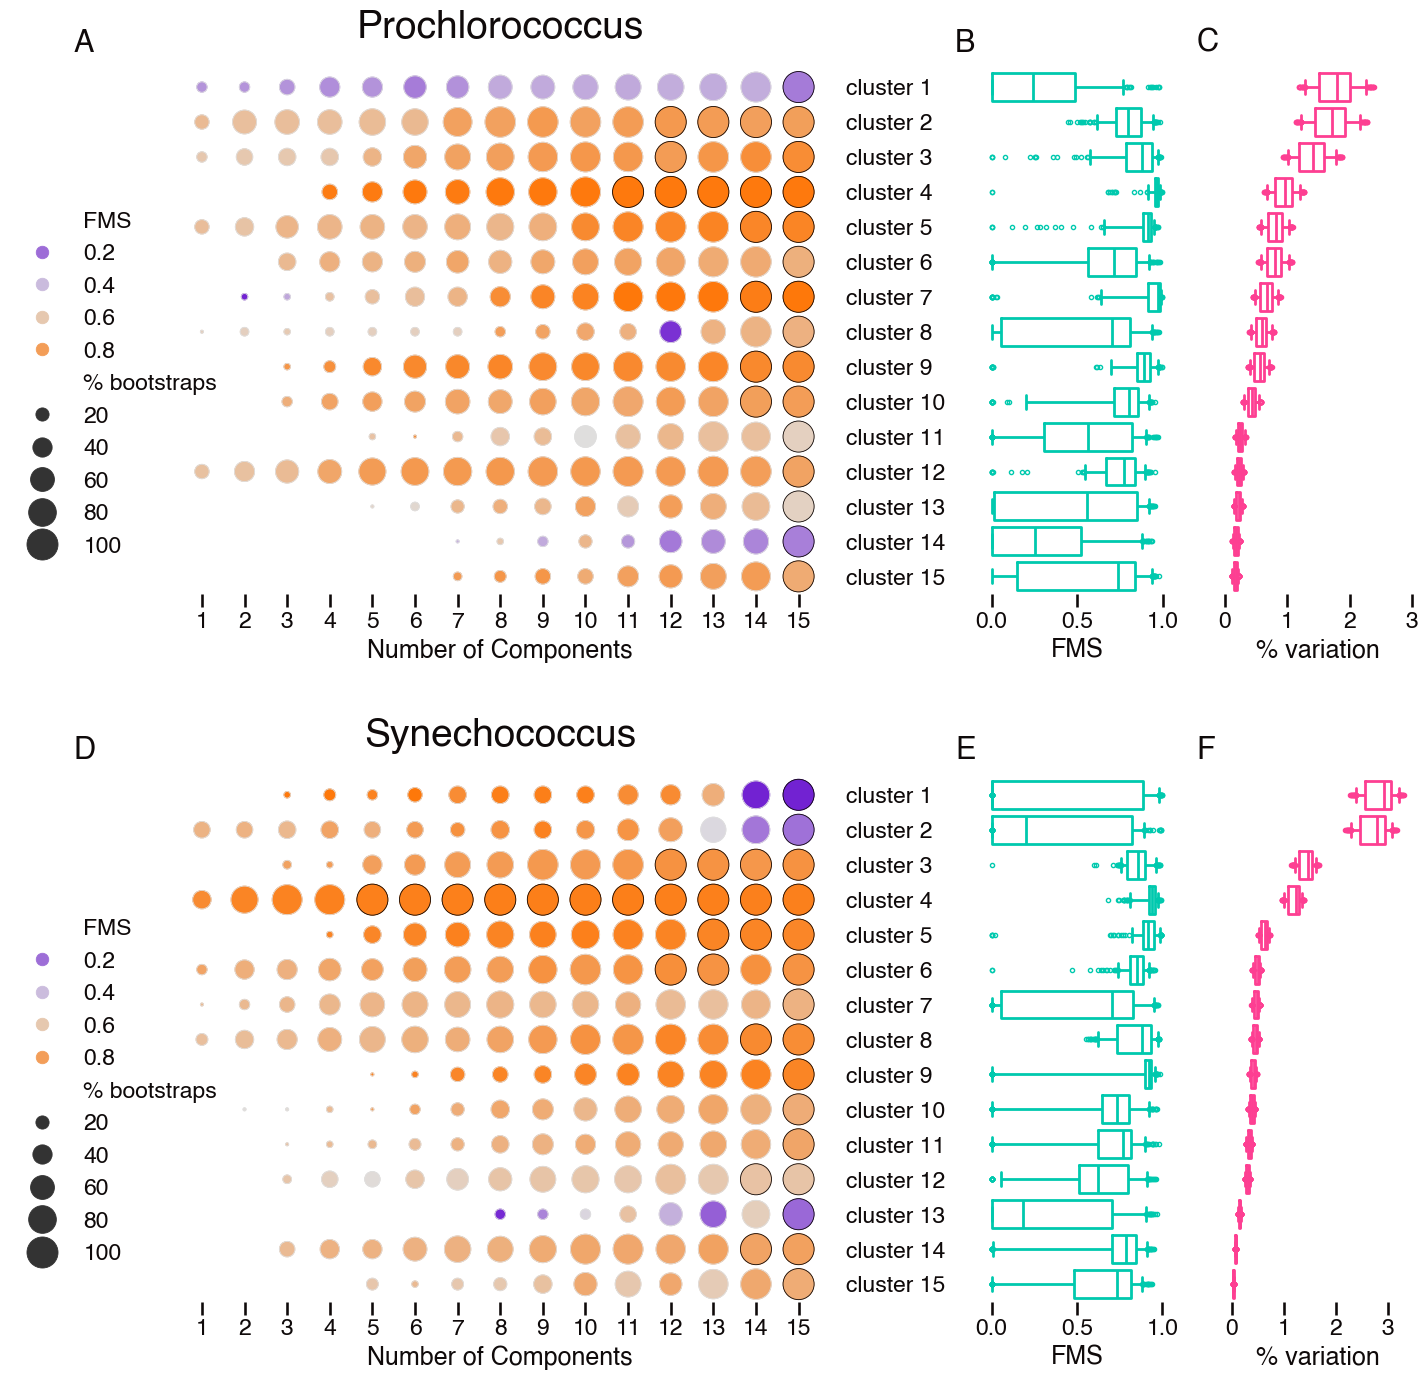

In [16]:
# component robustness plot

# make multiple plots sub
fig, axes = plt.subplots(
    2, 4, figsize=(16, 16), sharey='row', width_ratios=(7, .5, 2, 2), gridspec_kw={'hspace': 0.35}
)
annotations = {0: 'A', 2: 'B', 3: 'C', 4: 'D', 6: 'E', 7: 'F'}
annot_kws = dict(
    xy=(-0.15, 1.05), xycoords='axes fraction', va='center', ha='left', 
    weight='bold', fontsize=22, annotation_clip=False
)

for row, cyano in enumerate(['pro', 'syn']):

    # set up component robustness dataframe
    df = component_df[component_df['genus'] == cyano]
    df = df.groupby(['comparison_rank', 'reference_component']).agg(
        FMS = ('fms', 'median'), 
        bootstrap_count = ('fms', 'count')
    ).reset_index()
    # calculate bootstrap percentage
    df['total_bootstraps'] = len(comp_boots) * 3
    df.loc[df['comparison_rank'] == ranks[cyano]['ref'], 'total_bootstraps'] = (len(ref_boots) * 3) - 1
    df['% bootstraps'] = df['bootstrap_count'] / df['total_bootstraps'] * 100
    df['all bootstraps'] = df['% bootstraps'] == 100

    # set up component dataframe
    comp_stats_df = component_df[
        (component_df['genus'] == cyano) & 
        (component_df['comparison_rank'] == ranks[cyano]['ref'])
    ]

    # plot robustness patterns
    i = 0
    axes[row][i].annotate(annotations[row*4+i], **annot_kws)
    axes[row][i].annotate(
        {0: 'Prochlorococcus', 1: 'Synechococcus'}[row], xy=(0.5, 1.08), xycoords='axes fraction', 
        va='center', ha='center', weight='bold', style='italic', fontsize=28, annotation_clip=False
    )
    marker_palette = {True: line_color, False: neutral_color}
    sns.scatterplot(
        x='comparison_rank', 
        y='reference_component', 
        hue='FMS', 
        size='% bootstraps', 
        sizes=(5, 500), 
        edgecolor=None, 
        palette=div_cmap, 
        data=df, 
        legend='brief',
        ax=axes[row][i]
    ); 
    # hackey solution to fix legend freaking out over different edge colors
    sns.scatterplot(
        x='comparison_rank', 
        y='reference_component', 
        hue='FMS', 
        size='% bootstraps', 
        sizes=(5, 500), 
        edgecolor=df['all bootstraps'].map(marker_palette), 
        palette=div_cmap, 
        data=df, 
        legend=False,
        ax=axes[row][i]
    );
    axes[row][i].legend(loc='center right', alignment='right', bbox_to_anchor=(0.1, 0.4));
    axes[row][i].set(xlabel='Number of Components', xticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], ylabel=None)

    # skip axis for label space
    i = 1
    axes[row][i].tick_params(left=False, bottom=False, labelbottom=False)

    # plot component fms
    i = 2
    axes[row][i].annotate(annotations[row*4+i], **annot_kws)
    sns.boxplot(
        data=comp_stats_df, 
        x='fms', 
        y='comparison_component', 
        # estimator='median', 
        # errorbar=('pi', 50), 
        orient='h', 
        color=sns.color_palette()[2], 
        fill=False, whis=(5, 95), fliersize=3, 
        ax=axes[row][i]
    ); 
    axes[row][i].set(xlabel='FMS', xticks=[0, .5, 1], ylabel=None);
    axes[row][i].tick_params(left=False)

    # plot % variance explained
    i = 3
    axes[row][i].annotate(annotations[row*4+i], **annot_kws)
    sns.boxplot(
        data=var_df[var_df['genus'] == cyano], 
        x='explained_variation', 
        y='comparison_component', 
        # estimator='median', 
        # errorbar=('pi', 50), 
        orient='h', 
        color=sns.color_palette()[3], 
        fill=False, whis=(5, 95), fliersize=3, 
        ax=axes[row][i]
    ); 
    axes[row][i].tick_params(left=False)
    axes[row][i].set(xlabel='% variation', xticks=[0, 1, 2, 3], ylabel=None)

    # set cluster labels
    axes[row][0].tick_params(left=False, right=False, labelleft=False, labelright=True)
    axes[row][0].set_yticks(np.arange(15), [f'cluster {i+1}' for i in np.arange(15)]);

plt.savefig(outdir / 'component-robustness.png', bbox_inches='tight')


# List clusters by median FMS

In [12]:
# make comp_stats_df

comp_stats_df = pd.DataFrame()
for cyano in ['pro', 'syn']: 
    df = component_df[
        (component_df['genus'] == cyano) & 
        (component_df['comparison_rank'] == ranks[cyano]['ref'])
    ]
    if len(comp_stats_df) == 0:
        comp_stats_df = df
    else: 
        comp_stats_df = pd.concat([comp_stats_df, df])
        
# join explained variance
comp_stats_df = pd.merge(
    left=comp_stats_df, 
    right=var_df[['genus', 'comparison_bootstrap', 'comparison_replicate', 
                  'comparison_component', 'explained_variation']], 
    on=['genus', 'comparison_bootstrap', 'comparison_replicate', 'comparison_component']
)
comp_stats_df['cluster'] = comp_stats_df['comparison_component'] + 1

comp_stats_df.groupby(['genus', 'cluster']).median(
    ['fms', 'explained_variation']).reset_index().sort_values(
    ['genus', 'fms'], ascending=False
)


,genus,cluster,reference_bootstrap,reference_rank,reference_component,comparison_bootstrap,comparison_rank,comparison_component,fms,explained_variation
18,syn,4,26.0,15.0,3.0,50.0,15.0,3.0,0.938855,1.227992
23,syn,9,26.0,15.0,8.0,50.0,15.0,8.0,0.920032,0.423588
19,syn,5,26.0,15.0,4.0,50.0,15.0,4.0,0.913967,0.645180
22,syn,8,26.0,15.0,7.0,50.0,15.0,7.0,0.882265,0.469028
17,syn,3,26.0,15.0,2.0,50.0,15.0,2.0,0.855330,1.470425
20,syn,6,26.0,15.0,5.0,50.0,15.0,5.0,0.851639,0.499249
28,syn,14,26.0,15.0,13.0,50.0,15.0,13.0,0.786714,0.076691
25,syn,11,26.0,15.0,10.0,50.0,15.0,10.0,0.767286,0.343839
29,syn,15,26.0,15.0,14.0,50.0,15.0,14.0,0.736832,0.032746
24,syn,10,26.0,15.0,9.0,50.0,15.0,9.0,0.733367,0.397475


In [13]:
# print Prochlorococcus data

pro_comp_df = comp_stats_df[comp_stats_df['genus'] == 'pro']
pro_comp_df = pro_comp_df.groupby('cluster').median(
    ['fms', 'explained_variation']).reset_index().sort_values(
    'fms', ascending=False
)
cluster_list = pro_comp_df[pro_comp_df['fms'].gt(0.5)]['cluster'].to_list()
print(sorted(cluster_list))
print([f"pro{i}" for i in sorted(cluster_list)])
print(len(cluster_list))

pro_comp_df[['cluster', 'fms', 'explained_variation']]


[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15]
['pro2', 'pro3', 'pro4', 'pro5', 'pro6', 'pro7', 'pro8', 'pro9', 'pro10', 'pro11', 'pro12', 'pro13', 'pro15']
13


,cluster,fms,explained_variation
6,7,0.972817,0.678159
3,4,0.964806,0.964032
4,5,0.912380,0.824523
8,9,0.887499,0.566885
2,3,0.875237,1.422182
9,10,0.800639,0.443103
1,2,0.793683,1.724888
11,12,0.773226,0.233890
14,15,0.736388,0.176681
5,6,0.714975,0.814801


In [14]:
# print Synechococcus data

syn_comp_df = comp_stats_df[comp_stats_df['genus'] == 'syn']
syn_comp_df = syn_comp_df.groupby('cluster').median(
    ['fms', 'explained_variation']).reset_index().sort_values(
    'fms', ascending=False
)
cluster_list = syn_comp_df[syn_comp_df['fms'].gt(0.5)]['cluster'].to_list()
print(sorted(cluster_list))
print([f"syn{i}" for i in sorted(cluster_list)])
print(len(cluster_list))

syn_comp_df[['cluster', 'fms', 'explained_variation']]


[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]
['syn3', 'syn4', 'syn5', 'syn6', 'syn7', 'syn8', 'syn9', 'syn10', 'syn11', 'syn12', 'syn14', 'syn15']
12


,cluster,fms,explained_variation
3,4,0.938855,1.227992
8,9,0.920032,0.423588
4,5,0.913967,0.645180
7,8,0.882265,0.469028
2,3,0.855330,1.470425
5,6,0.851639,0.499249
13,14,0.786714,0.076691
10,11,0.767286,0.343839
14,15,0.736832,0.032746
9,10,0.733367,0.397475
